# Simple 1/V estimator
Source: doi:10.1093/mnras/stw756 (page 7)

## Imports, initial values

In [1]:
import numpy as np
from astropy.coordinates import Distance
from astropy.table import Table, hstack
from astropy.cosmology import Planck18
from astropy import units as u
import astropy.constants as asc
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import corner
import arviz as az

from astropy.modeling.models import Schechter1D
from astropy.modeling import models, fitting

# custom GAlaxy SELection functions
import gasel as gs

Complete Sky area in deg^2

In [2]:
min_ra = 190
min_dec = -5
max_ra = 220
max_dec = 5
buffer = 2.0

area = (np.deg2rad(max_ra) - np.deg2rad(min_ra)) * (np.cos(np.deg2rad(90-max_dec)) - np.cos(np.deg2rad(90-min_dec)))
area = area*((180/np.pi)**2)
print('This patch has an area of {:.2f} sqdeg'.format(area))

This patch has an area of 299.62 sqdeg


## Load the data & prepare/select

In [3]:
# Release directory path

specprod = 'iron'    # Internal name for most current data release
specprod_dir = '/global/cfs/cdirs/desi/spectro/redux/iron/'
print(specprod_dir)

/global/cfs/cdirs/desi/spectro/redux/iron/


In [5]:
ztile_cat = Table.read(f'{specprod_dir}/zcatalog/zall-tilecumulative-{specprod}.fits', hdu="ZCATALOG")

In [6]:
ztile_cat[200000:200002]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int32,bool,int64,bool
2305843042172556950,main,backup,20220315,20220315,-3.00809916038518e-05,8.17084131088571e-06,0,8122.131242808256,2642.9873816104127 .. 0.0,7926,STAR,K,5,1731.7716519866854,6,134,6134,3336,0,236.1111659842606,2.4452757496874202,6.997798,-4.627603,2015.5,5400.0,2305843009213693952,1,TGT,-144.61711,140.12033,25,0.5627646015238863,568,-1,--,345712,-1,GPSF,0.09782427,-99.0,-99.0,-99.0,0.0,0.0,-99.0,-99.0,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,4423852667484346112,G2,18.6984,19.790138,17.672045,0.82504624,G,25,2,0,2305843009213693952,0,288230376151711744,0,0,0,0,0,0,0,0,0,0,0,0,0,236.1111659842606,2.4452757496874202,40280,2,855.4842,2,1,0.00330267,0.004675114,0.0013395663,0.0014562567,236.11117934202923,0.04800739,2.445270189679835,0.0077114785,0.7914041,-144.5933,140.08015,12.523476,0.0053837355,2.5068247,3.1788597,33.164173,19.253931,0.122836754,0.0615563,620.75806,1.7215315,123.98336,0.0015768304,136.13423,911.63226,0.394868,2.4228117,9.204132e-07,6.9117856,1.8511989e-07,0.0,311.3585,1.4048325e-06,1.1787453,3.1866295,633.28156,8.6387005,126.49019,3.1804366,480.6569,930.88617,1.69645,5.6709976,1,True,0,False,1,True
2305843042176741438,main,backup,20220315,20220315,-0.00019829921610947787,3.6222601546171266e-07,0,93622.25726952829,885048.021980

In [7]:
ztile_cat.keep_columns(['TARGETID', 'SURVEY', 'PROGRAM', 'Z', 'ZERR', 'ZWARN', 'TARGET_RA', 'TARGET_DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'LASTNIGHT', 'SPECTYPE', 'BGS_TARGET'])

In [8]:
# lets use the whole sky

"""ii = ztile_cat['TARGET_RA']>(min_ra)
ii &= ztile_cat['TARGET_RA']<(max_ra)
ii &= ztile_cat['TARGET_DEC']>(min_dec)
ii &= ztile_cat['TARGET_DEC']<(max_dec)

ztile_cat = ztile_cat[ii]"""
print("All entries after localization selection", len(ztile_cat))

All entries after localization selection 30300000


In [9]:
#ztile_cat = ztile_cat[ztile_cat["PROGRAM"] == "bright"]

In [10]:
#print("All entries in BRIGHT data: ", len(ztile_cat))

In [11]:
ztile_cat = ztile_cat[ztile_cat["BGS_TARGET"] > 0]

In [12]:
print("All entries in BGS_TARGET > 0 data: ", len(ztile_cat))

All entries in BGS_TARGET > 0 data:  7079499


In [13]:
ztile_cat = ztile_cat[ztile_cat['ZWARN']==0]

In [14]:
ztile_cat = ztile_cat[ztile_cat['Z']>=0]
print("All entries after good redshift selection", len(ztile_cat))

All entries after good redshift selection 6833935


In [15]:
ztile_cat = ztile_cat[ztile_cat["FLUX_Z"] > 0.0]
print("All entries after Flux Z selection", len(ztile_cat))

All entries after Flux Z selection 6833928


In [16]:
ztile_cat = ztile_cat[ztile_cat["FLUX_R"] > 0.0]
print("All entries after Flux R selection", len(ztile_cat))

All entries after Flux R selection 6833928


In [17]:
ztile_cat = ztile_cat[ztile_cat["FLUX_G"] > 0.0]
print("All entries after Flux G selection", len(ztile_cat))

All entries after Flux G selection 6833919


In [18]:
ztile_cat = ztile_cat[ztile_cat["SPECTYPE"] == "GALAXY"]

In [19]:
print("All entries after Type (Galaxy) selection", len(ztile_cat))

All entries after Type (Galaxy) selection 6715300


### Calculate the apparent and absolute magnitudes from the given Fluxes (app mag both r and z-band flux, to correct the z limit() with a Planck Cosmology

In [20]:
# calculate the apparent magnitude of every galaxy (Planck Cosmology)
app_mag_z = gs.app_mag(ztile_cat["FLUX_Z"])
app_mag_r = gs.app_mag(ztile_cat["FLUX_R"])
app_mag_g = gs.app_mag(ztile_cat["FLUX_G"])

In [21]:
# calculate the absolute magnitude of every galaxy, not yet including a K-correction however with SDSS filters (Planck Cosmology)


### NO K-CORRECTION USED; SHOULD BE ABLE TO IMPLEMENT QUICKLY
abs_mag_z = gs.abs_mag(app_mag_z, ztile_cat["Z"], "z", "g - z", app_mag_g - app_mag_z)
abs_mag_r = gs.abs_mag(app_mag_r, ztile_cat["Z"], "r", "g - r", app_mag_g - app_mag_r)

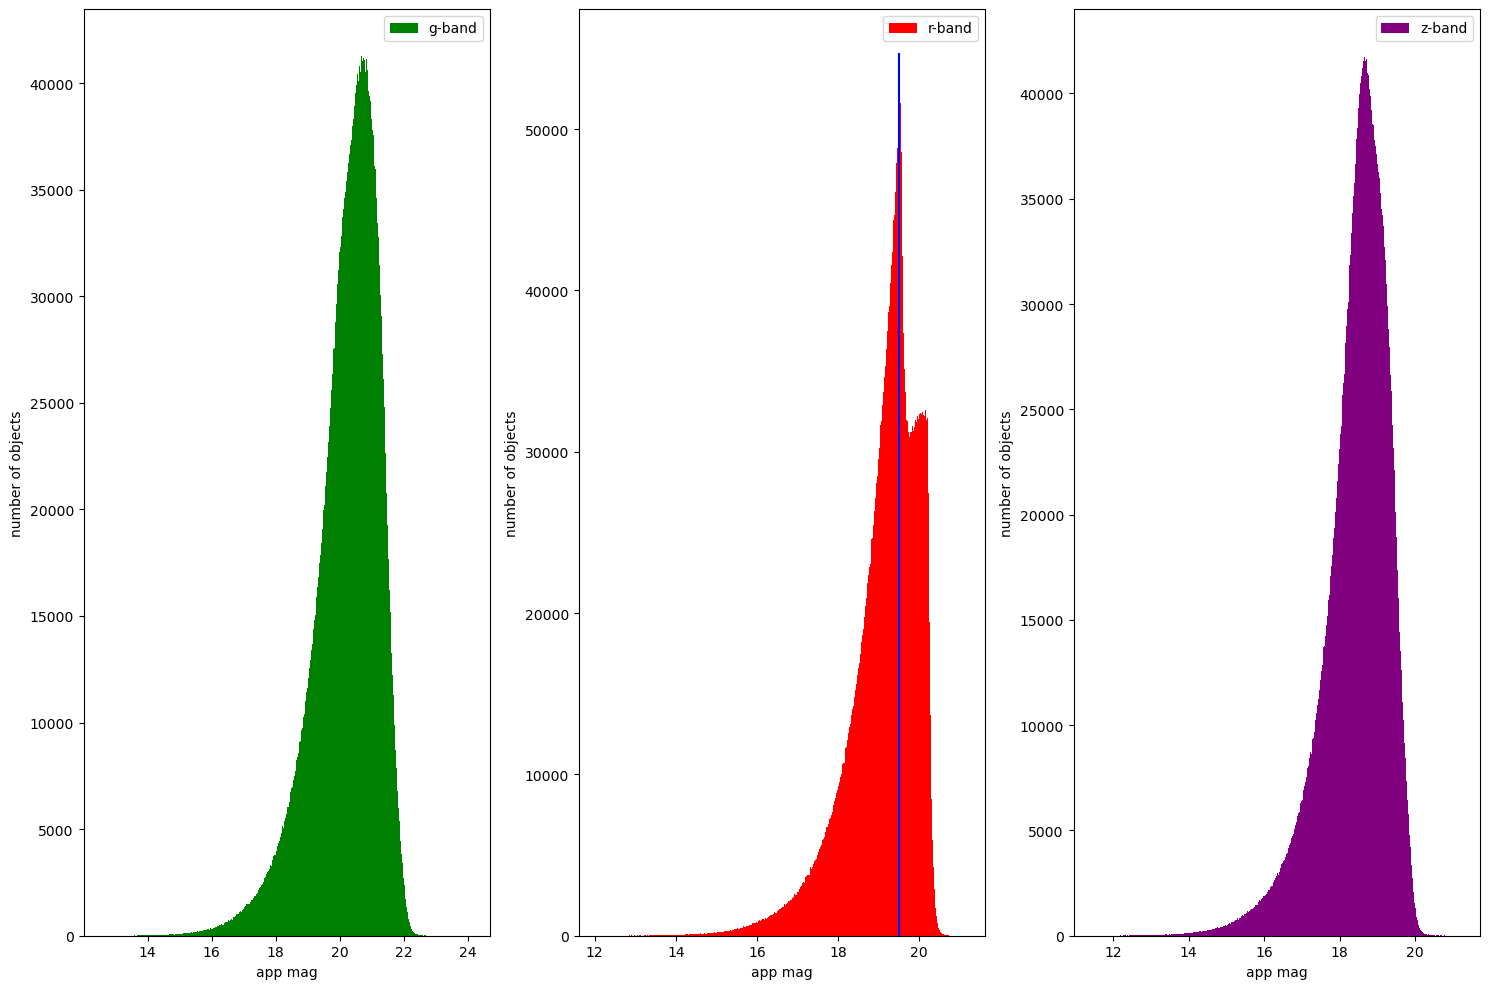

In [22]:
# plot magnitudes

fig, ax = plt.subplots(ncols = 3, figsize  = (15,10))

ax[0].hist(app_mag_g, bins = "auto", label = "g-band", color = "green")
ax[1].hist(app_mag_r, bins = "auto", label = "r-band", color = "red")

ymin,ymax = ax[1].get_ylim()
ax[1].vlines(19.5, ymin, ymax, color = "blue")

ax[2].hist(app_mag_z, bins = "auto", label = "z-band", color = "purple")

for axis in ax:
    axis.set_xlabel("app mag")
    axis.set_ylabel("number of objects")
    axis.legend()

plt.tight_layout()
plt.show()


In [23]:
np.min(abs_mag_r)

<Quantity -32.51408538>

In [24]:
np.sort(abs_mag_r)[::-1]

<Quantity [ 10.03394761,   9.7892111 ,   9.3652343 , ..., -31.50353698,
           -32.4753631 , -32.51408538]>

In [25]:
corner_plot_data = {"G": app_mag_g, "R": app_mag_r, "Z": app_mag_z}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": app_mag_r>19.5})

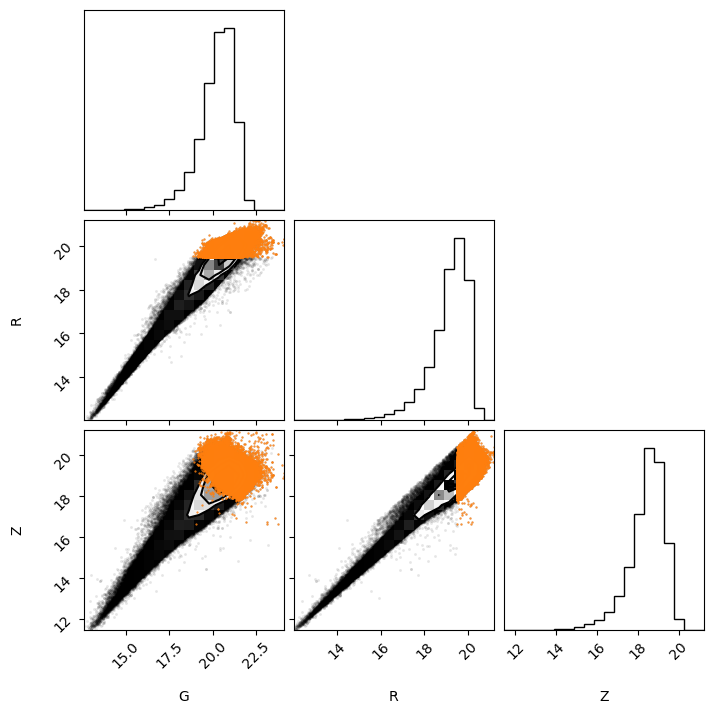

In [26]:
figure = corner.corner(corner_plot_data, divergences = True)

In [27]:
diff = [app_mag_r[q]-app_mag_z[q] for q in range(len(app_mag_r))]

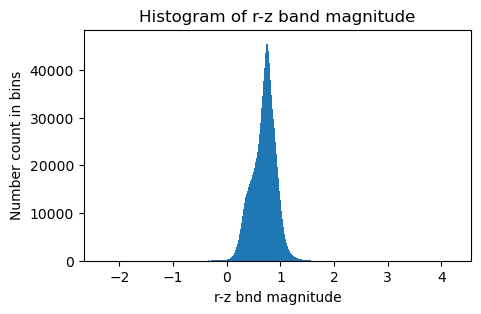

In [28]:
fig, ax = plt.subplots(figsize = (5,3))

ax.hist(diff, bins='auto')
ax.set_xlabel("r-z bnd magnitude")
ax.set_ylabel("Number count in bins")
plt.title("Histogram of r-z band magnitude")
plt.show()

In [29]:
avg_diff = np.mean(diff)

In [30]:
avg_diff

0.6932015

In [31]:
lums_z = gs.lum(abs_mag_z, band = "z")

In [32]:
lums_r = gs.lum(abs_mag_r, band = "r")

In [33]:
offset = 0

In [34]:
m_limit_z = 19.5-avg_diff+offset # r-band magnitude limit for BGS Bright, would need to convert it to z-band magnitude

In [35]:
m_limit_z

18.80679851770401

In [36]:
m_limit_r = 19.5

In [37]:
lumin_limits_r = gs.lum_lim(lums_r, m_limit_r, app_mag_r)

In [38]:
lumin_limits_z = gs.lum_lim(lums_z, m_limit_z, app_mag_z)

In [39]:
# cornerplot (corner, chainconsumer) to see whether I miss peculiar galaxies
# redshift

In [40]:
ztile_cat = hstack([ztile_cat, Table({"APP_MAG_G": app_mag_g}),  Table({"APP_MAG_R": app_mag_r}), Table({'APP_MAG_Z': app_mag_z}), Table({'ABS_MAG_R': abs_mag_r}), Table({'ABS_MAG_Z': abs_mag_z}), Table({"LUM_Z": lums_z}), Table({"LUM_R": lums_r}), Table({'LUM_LIMIT_Z': lumin_limits_z}), Table({'LUM_LIMIT_R': lumin_limits_r})])

In [41]:
ztile_cat

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,BGS_TARGET,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,int64,float32,float32,float32,float64,float64,float64,float64,float64,float64
39627794770034947,main,bright,20210609,0.3434721391420429,1.342083221411785e-05,0,GALAXY,238.50759776555574,0.34570032896999453,5.2453914,15.696667,32.585148,131074,20.700556,19.51048,18.717451,-21.853648921320655,-22.646678706476905,1.3308009390017957e+37,2.973673832580578e+36,1.225671160061615e+37,3.002518292362612e+36
39627800814030770,main,bright,20210609,0.3364164868317523,8.804215398699183e-05,0,GALAXY,238.86925764320216,0.5462878205990764,2.6192536,12.288538,28.288542,65537,21.454556,19.776249,18.870974,-21.53547611587976,-22.440751460728393,1.1008856235937366e+37,2.2183200729538803e+36,1.1679171920892747e+37,2.861039131900351e+36
39627800814034117,main,bright,20210609,0.05057095057762226,3.4408071768163042e-06,0,GALAXY,238.97427987123274,0.5936892383771224,15.881108,21.43084,26.615164,131074,19.497799,19.172401,18.937178,-17.660648326042995,-17.895872096184597,1.6741349172013262e+35,6.253067158915928e+34,1.8877388899891733e+35,4.624381613131109e+34
39627806853832150,main,bright,20210609,0.20535005655734515,6.544560905644702e-05,0,GALAXY,238.98559207893408,0.6532164248555011,6.4470363,21.232624,44.302246,131074,20.4766,19.182491,18.383936,-20.908032215350687,-21.706587589496195,5.598564059654624e+36,1.2446482958443069e+36,3.7925510133058413e+36,9.290587524928386e+35
39627794770035576,main,bright,20210609,0.5576890809194137,4.030136486491741e-05,0,GALAXY,238.53128524271153,0.31999237818547677,4.1716576,11.685528,24.258741,65537,20.949228,19.83088,19.03783,-22.780445560658023,-23.5734944193006,3.124923454955416e+37,6.982516762238223e+36,3.8659117384006237e+37,9.470298394567037e+36
39627800809834103,main,bright,20210609,0.4583588870397052,3.54347398828501e-05,0,GALAXY,238.5556541498655,0.4011308785958288,2.4766326,7.069482,13.766501,65537,21.515347,20.376532,19.65294,-21.724859751048,-22.44845060187808,1.1087199362605841e+37,2.6410563233394984e+36,2.4170105924208417e+37,5.920934969853397e+36
39627800809833898,main,bright,20210609,0.07188346329477685,6.645182858719224e-06,0,GALAXY,238.54774476684366,0.47077639012926553,19.185844,34.291576,55.36728,131074,19.292547,18.662031,18.141867,-18.967073407406744,-19.487237897152838,7.249979438860656e+35,2.0828746082376754e+35,3.929740325834305e+35,9.626659423137548e+34
39627800809834304,main,bright,20210609,0.45844369682435865,9.308965311007976e-05,0,GALAXY,238.56231240557304,0.4427502193462382,2.162092,13.665881,44.037453,131074,21.662815,19.660906,18.390446,-22.44096331440722,-23.7114234431914,3.5482237075569103e+37,5.107625992906154e+36,2.418074547575272e+37,5.923541159019292e+36


In [42]:
ztile_cat.group_by("ABS_MAG_R")[::-1]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,BGS_TARGET,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,int64,float32,float32,float32,float64,float64,float64,float64,float64,float64
39633426772398076,main,bright,20211117,8.832994399959636e-08,1.5572978360394045e-06,0,GALAXY,109.70193892522676,63.550657203274625,134.2298,63.274323,114.605804,514,17.180378,17.996931,17.351984,10.033947606137959,9.389000554136006,2.0409924321461913e+24,5.2270267206441935e+23,5.344602658100878e+23,1.3092637638167052e+23
39628217203564121,main,bright,20220518,2.453286088901789e-07,7.156022637657443e-05,0,GALAXY,261.0566767736198,17.906628533141106,6.3465905,10.276418,20.896223,65537,20.493649,19.970396,19.199831,9.789211104977186,9.018646072018202,2.870669448146994e+24,6.548612921252988e+23,4.1228356783785896e+24,1.0099682832160275e+24
39628476315074855,main,bright,20220513,2.2471759018066488e-07,2.4475387299718475e-05,0,GALAXY,237.23672206725755,29.758537520441035,21.440014,18.098995,13.068511,131074,19.171938,19.355864,19.709435,9.36523430497782,9.718805243088172,1.5063278954690132e+24,9.67698439445957e+23,3.459184637095206e+24,8.47394140217541e+23
39633465817172969,main,bright,20210629,3.3733052615786944e-07,3.833683214212986e-05,0,GALAXY,260.8141439036602,67.28394587456856,5.6187196,14.958575,28.718401,514,20.625906,19.562775,18.854599,8.69005233069856,7.981876671518872,7.459177596258753e+24,1.802240854635345e+24,7.794907847425125e+24,1.9095132492546722e+24
39632972176955413,main,bright,20210523,6.147233142420875e-07,5.773499892245288e-05,0,GALAXY,272.53784350911894,34.490496511470454,2.6958175,9.059772,16.904442,265,21.423273,20.107206,19.429998,7.931363350609086,7.254155403831742,1.458073626342285e+25,3.624836501241628e+24,2.588565946046108e+25,6.341192685021478e+24
39633358245856200,main,bright,20220209,7.536340832652006e-07,1.3619574800754047e-05,0,GALAXY,114.81974309174386,57.69330230931022,2.0959713,9.201053,22.276655,257,21.696537,20.090406,19.130375,7.472158959449086,6.512127450049672,2.887956424577386e+25,5.533121143908416e+24,3.890639851363996e+25,9.530874201232307e+24
39633407864474358,main,bright,20220120,4.90075347976207e-07,3.370461137396857e-06,0,GALAXY,194.6531081948137,61.78253660523801,10.046743,23.168144,44.53956,514,19.994936,19.087772,18.378136,7.404013721403697,6.694377033171275,2.4416915642706366e+25,5.891532450554751e+24,1.6452257269852644e+25,4.030298509204762e+24
39633329712006916,main,bright,20210627,4.003569356709974e-07,6.010210763593185e-05,0,GALAXY,276.31541562363225,55.52552165821743,31.848166,38.2261,21.030245,514,18.742289,18.5441,19.192888,7.2994188113728455,7.948207263521283,7.694115663218691e+24,6.487333701228458e+24,1.0979800579681803e+25,2.689714382593629e+24


In [43]:
ztile_cat_r_cut = ztile_cat

In [44]:
len(ztile_cat_r_cut)

6715300

In [45]:
ztile_cat_r_cut = ztile_cat[ztile_cat["APP_MAG_R"] < m_limit_r]

In [46]:
len(ztile_cat_r_cut)

4185038

In [47]:
ztile_cat_r_cut  = ztile_cat_r_cut[ztile_cat_r_cut["Z"]>0.02]
ztile_cat_r_cut  = ztile_cat_r_cut[ztile_cat_r_cut["Z"]<0.6]

In [48]:
len(ztile_cat_r_cut)

4151926

In [49]:
# ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]< 0.6]
# ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]> 0.1]

In [50]:
# ztile_cat_r_cut = ztile_cat_r_cut[ztile_cat_r_cut["Z"] > 0.1]

In [51]:
z_max_data = np.max(ztile_cat_r_cut["Z"])
z_min_data = np.min(ztile_cat_r_cut["Z"])
print("z min and max in sample: ", z_min_data, z_max_data)

z min and max in sample:  0.02000172125340918 0.5999935242288166


In [52]:
ztile_cat_r_cut

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,BGS_TARGET,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,int64,float32,float32,float32,float64,float64,float64,float64,float64,float64
39627800814034117,main,bright,20210609,0.05057095057762226,3.4408071768163042e-06,0,GALAXY,238.97427987123274,0.5936892383771224,15.881108,21.43084,26.615164,131074,19.497799,19.172401,18.937178,-17.660648326042995,-17.895872096184597,1.6741349172013262e+35,6.253067158915928e+34,1.8877388899891733e+35,4.624381613131109e+34
39627806853832150,main,bright,20210609,0.20535005655734515,6.544560905644702e-05,0,GALAXY,238.98559207893408,0.6532164248555011,6.4470363,21.232624,44.302246,131074,20.4766,19.182491,18.383936,-20.908032215350687,-21.706587589496195,5.598564059654624e+36,1.2446482958443069e+36,3.7925510133058413e+36,9.290587524928386e+35
39627800809833898,main,bright,20210609,0.07188346329477685,6.645182858719224e-06,0,GALAXY,238.54774476684366,0.47077639012926553,19.185844,34.291576,55.36728,131074,19.292547,18.662031,18.141867,-18.967073407406744,-19.487237897152838,7.249979438860656e+35,2.0828746082376754e+35,3.929740325834305e+35,9.626659423137548e+34
39627800805644591,main,bright,20210609,0.3995698156040027,0.00010358593919617879,0,GALAXY,238.45010756064576,0.38197122991464705,5.4006557,31.975393,85.936165,131074,20.668884,18.73796,17.66456,-23.010702849326442,-24.084103346762966,5.00130055876505e+37,8.63206898430126e+36,1.746576129836541e+37,4.2785757465299284e+36
39627800805645550,main,bright,20210609,0.1949191436125688,8.731670676715399e-06,0,GALAXY,238.48098242125738,0.4818731730539087,8.42878,17.441359,30.110353,131074,20.185589,19.39605,18.803211,-20.568228258554,-21.161066545907516,3.3874136590878744e+36,9.101753429482591e+35,3.37623879051674e+36,8.270749681484116e+35
39627800814031490,main,bright,20210609,0.07185348993713707,2.179654947232196e-06,0,GALAXY,238.8906323412064,0.4825049414117846,31.183992,54.977596,84.01239,131074,18.765171,18.149536,17.689142,-19.478617929866374,-19.939011835506022,1.099123137506095e+36,3.3364216804358415e+35,3.9263016918623874e+35,9.618234772793508e+34
39627800814032250,main,bright,20210609,0.08880965563053493,2.073611729100794e-05,0,GALAXY,238.91538743634203,0.5238096399672825,164.72557,363.29105,667.39343,131074,16.958097,16.099363,15.439045,-22.013937807747745,-22.674256182381534,1.3650359492295998e+37,3.4467428692519355e+36,6.1382211496030746e+35,1.5036758896146817e+35
39627812902011811,main,bright,20210609,0.20326918016152312,3.3393101947028825e-05,0,GALAXY,239.2853445362934,0.8926061595380618,8.174518,24.801294,59.551025,131074,20.218845,19.013813,18.062777,-21.052006661630337,-22.003043114877407,7.356290344040627e+36,1.4211385728790715e+36,3.70723321031127e+36,9.081584546191193e+35


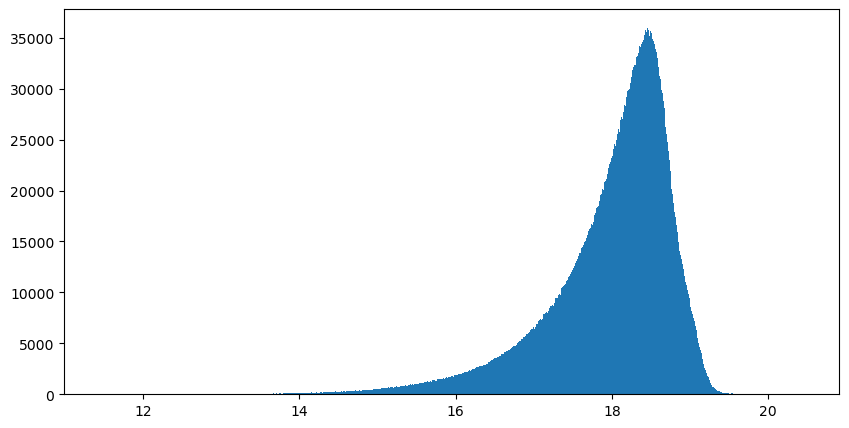

In [53]:
fig, ax = plt.subplots(figsize = (10,5))

ax.hist(ztile_cat_r_cut["APP_MAG_Z"], bins = "auto")
ax.vlines(m_limit_z, 0, 4000)

plt.show()

In [54]:
corner_plot_data = {"G": ztile_cat_r_cut["APP_MAG_G"], "R": ztile_cat_r_cut["APP_MAG_R"], "Z": ztile_cat_r_cut["APP_MAG_Z"]}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z})

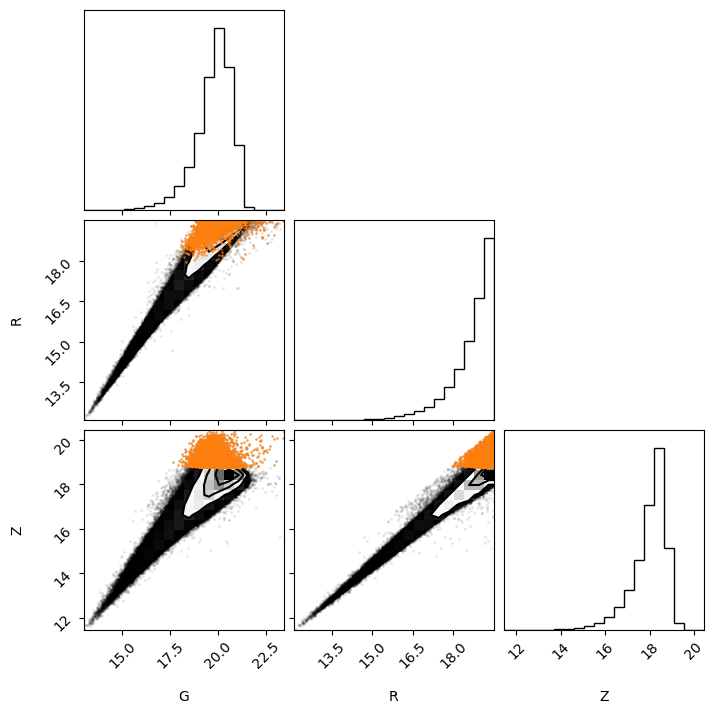

In [55]:
figure = corner.corner(corner_plot_data, divergences = True)

In [56]:
corner_plot_data = {"G-R": ztile_cat_r_cut["APP_MAG_G"]-ztile_cat_r_cut["APP_MAG_R"], "R-Z": ztile_cat_r_cut["APP_MAG_R"] - ztile_cat_r_cut["APP_MAG_Z"]}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z})

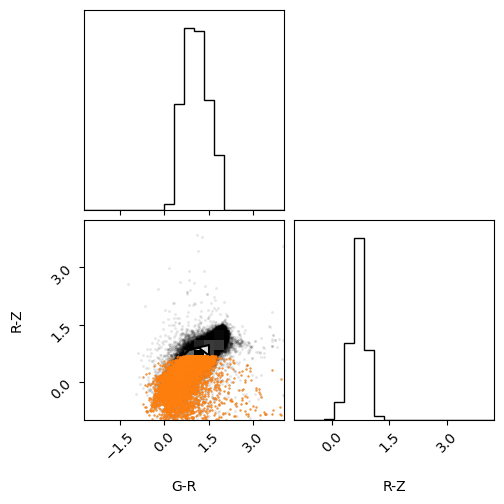

In [57]:
figure = corner.corner(corner_plot_data, divergences = True)

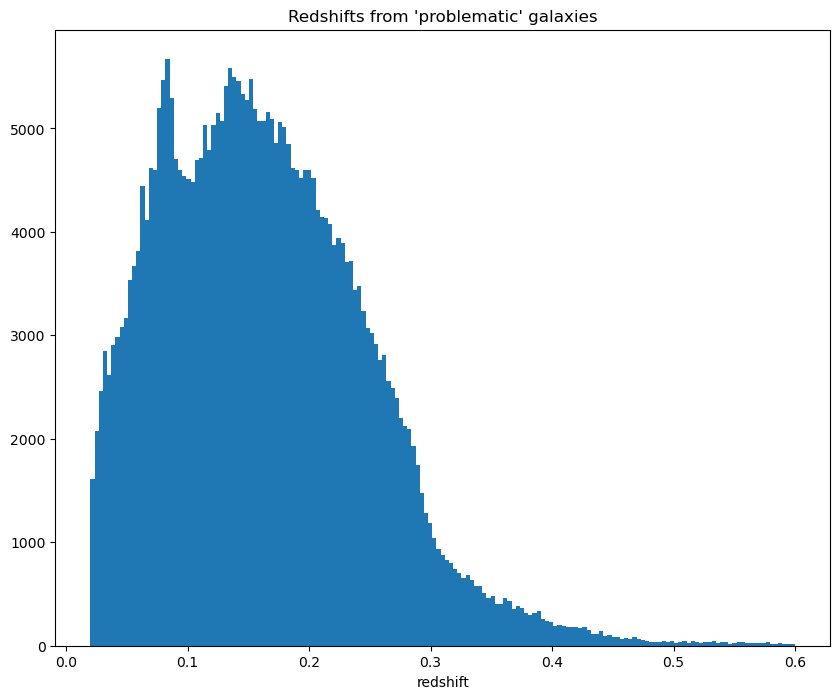

In [58]:
fig, ax = plt.subplots(figsize = (10,8))

ax.hist(ztile_cat_r_cut["Z"][ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z], bins = "auto")
ax.set_xlabel("redshift")
plt.title("Redshifts from 'problematic' galaxies")
plt.show()

In [59]:
len(ztile_cat_r_cut[ztile_cat_r_cut["APP_MAG_R"]>m_limit_z]), len(ztile_cat_r_cut), len(ztile_cat_r_cut[ztile_cat_r_cut["APP_MAG_R"]>m_limit_z])/len(ztile_cat_r_cut)

(2305793, 4151926, 0.5553550328209125)

In [60]:
ztile_cat_grouped_by_AppMag = ztile_cat_r_cut.group_by("APP_MAG_R")

In [61]:
ztile_cat_grouped_by_AppMag

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,BGS_TARGET,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,int64,float32,float32,float32,float64,float64,float64,float64,float64,float64
39627969127253006,main,bright,20220419,0.024544046726322488,5.966889515505232e-06,0,GALAXY,214.53844952675536,7.564536759237859,6338.3755,14347.159,26570.107,131074,12.995055,12.108086,11.439017,-23.114208061669267,-23.783276398156083,3.79098595382693e+37,9.495481398720071e+36,4.281928290388381e+34,1.0489410970420863e+34
39627731532514190,main,bright,20220205,0.029458797644051855,1.5138868332320103e-05,0,GALAXY,69.2817158838786,-2.3046084837581726,5971.9106,13817.872,26571.746,131074,13.059717,12.148897,11.438951,-23.477600176965396,-24.18754680935065,5.501236803560023e+37,1.327008893458684e+37,6.213278645458547e+34,1.5220632924772966e+34
39627760913616335,main,bright,20220113,0.027136413402110766,6.108009818466532e-06,0,GALAXY,20.59914382981807,-0.8751674946182008,6302.4824,13385.562,25160.797,131074,13.001221,12.183409,11.498189,-23.261069037060835,-23.946288801770308,4.40511384524536e+37,1.087079679097752e+37,5.254278777924024e+34,1.287137451230112e+34
39632976203484267,main,bright,20220514,0.024041862878378048,9.854647789661673e-06,0,GALAXY,203.6050967666297,34.69043122070213,5654.614,12431.319,21320.857,514,13.118993,12.263707,11.677989,-22.912889979735183,-23.49860813464241,2.9166537157714947e+37,7.888415078647184e+36,4.105449876452015e+34,1.0057095020525478e+34
39627751988135128,main,bright,20210531,0.024239207980337386,9.115242061499695e-06,0,GALAXY,208.55938532902266,-1.4364608724968224,6088.599,12267.031,21484.447,131074,13.038707,12.2781515,11.669689,-22.91651409599082,-23.52497642967002,2.988354999482838e+37,7.914790085439207e+36,4.174344862814127e+34,1.0225865030327924e+34
39627842576712818,main,bright,20220313,0.02384192658996628,4.997516188279899e-06,0,GALAXY,208.04205176019414,2.325102268610591,5639.6,11997.294,21450.41,131074,13.12188,12.302292,11.671411,-22.85585024663422,-23.486731556143496,2.8849230822563773e+37,7.484690755514486e+36,4.036258105486339e+34,9.887590519791066e+33
39633442668808288,main,bright,20211119,0.022480509922322246,6.830195184023422e-06,0,GALAXY,113.26947530851652,65.07915476497605,5028.5884,11936.205,20378.465,514,13.246385,12.307835,11.727071,-22.7204420455367,-23.301205862370196,2.431778200765494e+37,6.607095449476773e+36,3.581233703971663e+34,8.772926603988605e+33
39627577400231002,main,bright,20220604,0.022521662814615817,9.752935305297344e-06,0,GALAXY,203.0557960051525,-8.786251489799396,5366.7705,11792.159,21706.02,131074,13.175717,12.321016,11.658549,-22.711298078415503,-23.373765081284155,2.5998461493092016e+37,6.551684778798434e+36,3.594576775324863e+34,8.805611477086616e+33


In [62]:
ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[::-1]

In [63]:
ztile_cat_grouped_by_AppMag[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,BGS_TARGET,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,int64,float32,float32,float32,float64,float64,float64,float64,float64,float64
39628512461591304,main,dark,20220409,0.5232104210989278,6.441367281246471e-05,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,131074,21.34423,19.499998,18.336449,-22.944699710552882,-24.108249133770656,5.11377092444133e+37,8.122947510778128e+36,3.3158980440905456e+37,8.122933469981502e+36
39627744803293140,main,bright,20220210,0.29393356192632125,5.053998841406768e-06,0,GALAXY,140.3418958135519,-1.7572070594922846,8.420731,15.848966,24.012398,131074,20.186626,19.499998,19.048912,-21.47299117234912,-21.924077216660642,6.840258315172543e+36,2.0942582339236586e+36,8.549047573435154e+36,2.0942546139256338e+36
39628512461591304,main,bright,20220317,0.5233237733268103,0.00014110804655666955,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,131074,21.34423,19.499998,18.336449,-22.945264178866502,-24.108813602084275,5.116430237192587e+37,8.127171684721852e+36,3.3176224095501663e+37,8.127157636623595e+36
39627603929204288,main,bright,20211021,0.09985713084547924,9.501685612959509e-06,0,GALAXY,359.06996685968784,-7.731517222708435,9.3054495,15.848953,23.134731,131074,20.078156,19.499998,19.089338,-18.883915639575875,-19.294575429614937,6.071161529616348e+35,1.9293011292831737e+35,7.875670467120089e+35,1.929297794419228e+35
39628121997053964,main,bright,20220122,0.2046669597299606,6.631007630176025e-05,0,GALAXY,124.08490860435361,14.009380623384853,5.1329536,15.848953,30.459774,131074,20.724081,19.499998,18.790684,-20.582441422326326,-21.291755768639803,3.820708666564449e+36,9.221686027102699e+35,3.7644181027728915e+36,9.221670087098423e+35


In [64]:
ztile_cat_grouped_by_AppMag_sel = ztile_cat_grouped_by_AppMag[:int(0.2*len(ztile_cat_grouped_by_AppMag))]

In [65]:
np.max(ztile_cat_grouped_by_AppMag["LUM_R"]), np.min(ztile_cat_grouped_by_AppMag["LUM_R"]), np.max(ztile_cat_grouped_by_AppMag_sel["LUM_R"]), np.min(ztile_cat_grouped_by_AppMag_sel["LUM_R"])

(7.964548294830565e+38,
 7.030270110489212e+33,
 1.348413834165045e+37,
 7.030270110489212e+33)

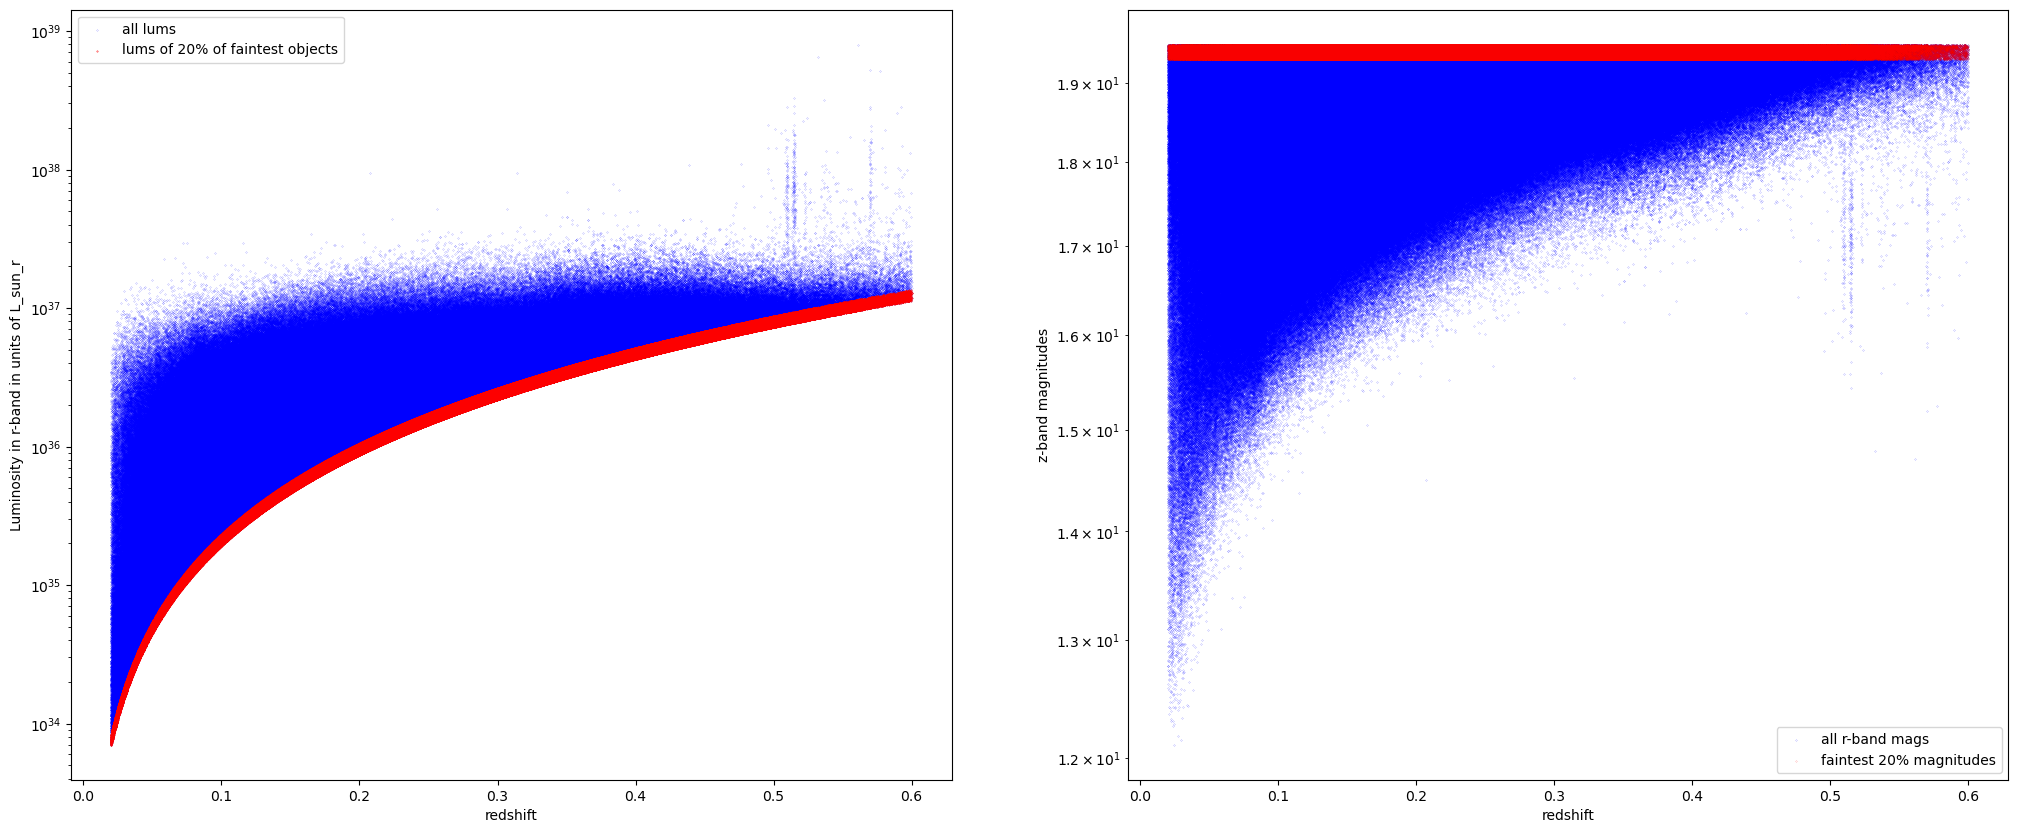

In [66]:
fig, ax = plt.subplots(ncols = 2, figsize = (25,10))

ax[0].scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"], s = 0.01, color = "blue", label = "all lums")
ax[0].scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_R"], s = 0.1, color = "red", label ="lums of 20% of faintest objects")

ax[1].scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["APP_MAG_R"], s = 0.01, color = "blue", label = "all r-band mags")
ax[1].scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["APP_MAG_R"], s = 0.01, color = "red", label = "faintest 20% magnitudes")


ax[0].set_xlabel("redshift")
ax[0].set_ylabel("Luminosity in r-band in units of L_sun_r")
ax[0].set_yscale("log")
#ax.set_xlim(0.08,.6)
#ax.set_ylim(10**3,10**5)
ax[0].legend()

ax[1].set_xlabel("redshift")
ax[1].set_ylabel("z-band magnitudes")
ax[1].set_yscale("log")
ax[1].legend()

plt.show()

In [67]:
ztile_cat_grouped_by_AppMag_sel

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,BGS_TARGET,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,int64,float32,float32,float32,float64,float64,float64,float64,float64,float64
39628512461591304,main,dark,20220409,0.5232104210989278,6.441367281246471e-05,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,131074,21.34423,19.499998,18.336449,-22.944699710552882,-24.108249133770656,5.11377092444133e+37,8.122947510778128e+36,3.3158980440905456e+37,8.122933469981502e+36
39627744803293140,main,bright,20220210,0.29393356192632125,5.053998841406768e-06,0,GALAXY,140.3418958135519,-1.7572070594922846,8.420731,15.848966,24.012398,131074,20.186626,19.499998,19.048912,-21.47299117234912,-21.924077216660642,6.840258315172543e+36,2.0942582339236586e+36,8.549047573435154e+36,2.0942546139256338e+36
39628512461591304,main,bright,20220317,0.5233237733268103,0.00014110804655666955,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,131074,21.34423,19.499998,18.336449,-22.945264178866502,-24.108813602084275,5.116430237192587e+37,8.127171684721852e+36,3.3176224095501663e+37,8.127157636623595e+36
39627603929204288,main,bright,20211021,0.09985713084547924,9.501685612959509e-06,0,GALAXY,359.06996685968784,-7.731517222708435,9.3054495,15.848953,23.134731,131074,20.078156,19.499998,19.089338,-18.883915639575875,-19.294575429614937,6.071161529616348e+35,1.9293011292831737e+35,7.875670467120089e+35,1.929297794419228e+35
39628121997053964,main,bright,20220122,0.2046669597299606,6.631007630176025e-05,0,GALAXY,124.08490860435361,14.009380623384853,5.1329536,15.848953,30.459774,131074,20.724081,19.499998,18.790684,-20.582441422326326,-21.291755768639803,3.820708666564449e+36,9.221686027102699e+35,3.7644181027728915e+36,9.221670087098423e+35
39628476700950758,main,bright,20220516,0.3259818141363389,6.238839403178226e-05,0,GALAXY,263.6795480562096,29.86452318803688,3.723798,15.848975,34.660423,131074,21.072535,19.499996,18.650415,-21.73234125303462,-22.581922017805127,1.2537484905573515e+37,2.6593179432084494e+36,1.085567959416129e+37,2.6593085912540695e+36
39632980439731049,main,bright,20211119,0.3920554604374992,0.0001069086853427979,0,GALAXY,150.6531448929639,34.96696871050341,2.9577417,15.848981,37.448135,514,21.3226,19.499996,18.566425,-22.20016403625852,-23.133734898074927,2.084181685521736e+37,4.091658480477172e+36,1.670267935524208e+37,4.091644091448006e+36
39628424783860798,main,bright,20211019,0.11867997911647223,2.984646281755426e-05,0,GALAXY,345.3853896159446,27.331097062096124,10.300225,15.848995,22.347721,131074,19.967884,19.499996,19.126917,-19.2856263190302,-19.658705618956958,8.490316178431994e+35,2.793085886293674e+35,1.1401738019992318e+36,2.7930760639210415e+35


In [68]:
lower_limit_z = np.min(ztile_cat_grouped_by_AppMag["Z"]) # np.min(faint_mags["Z"]) # get the limits of redshift in this sample
upper_limit_z = np.max(ztile_cat_grouped_by_AppMag["Z"]) # np.max(faint_mags["Z"])
delta_z = 0.005
bins = np.arange(lower_limit_z, upper_limit_z, delta_z)
num_of_bins_z = len(bins)

In [69]:
lower_limit_z, upper_limit_z, num_of_bins_z

(0.02000172125340918, 0.5999935242288166, 116)

In [70]:
LUM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin
LUM_LIM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin

cnt = 0
for bins_left_edge in bins[:num_of_bins_z-1]:
    # this is where we select all the galaxies that lie in the z range ([start, stop))
    
    # z-range selection
    ii = ztile_cat_grouped_by_AppMag_sel['Z']>=(bins_left_edge)
    ii &= ztile_cat_grouped_by_AppMag_sel['Z']<(bins_left_edge+delta_z)
    dat = ztile_cat_grouped_by_AppMag_sel[ii]

    # select only z-band luminosity (limit)
    LUM = dat["LUM_R"]
    LUM_LIM = dat["LUM_LIMIT_R"]
    
    # sort this data ascending
    LUM = np.sort(LUM)
    LUM_LIM = np.sort(LUM_LIM)
    
    # impose the same cut as in the paper, at 95%. This is the mass limit value
    LUM_cut = int(0.95*len(LUM))
    LUM_LIM_cut = int(0.95*len(LUM_LIM))

    # if there was no data in this bin, just store a 0
    if len(LUM) == 0:
        LUM = [0]
    if len(LUM_LIM) == 0:
        LUM_LIM = [0]
    
    # now store this luminosity (limit) value for the whole redshift range
    LUM_95[cnt] = LUM[LUM_cut] # this is the 95% lum per bin
    LUM_LIM_95[cnt] = LUM_LIM[LUM_LIM_cut] # this is the "Luminosity Limit" value per bin
    cnt += 1

In [71]:
stop_at = np.argmin(LUM_LIM_95[1:])
if stop_at == 0:
    stop_at = len(LUM_LIM_95)

In [72]:
stop_at

115

Fit values:  7250078417.5292425 -992575750.5438274 58372017.80495243


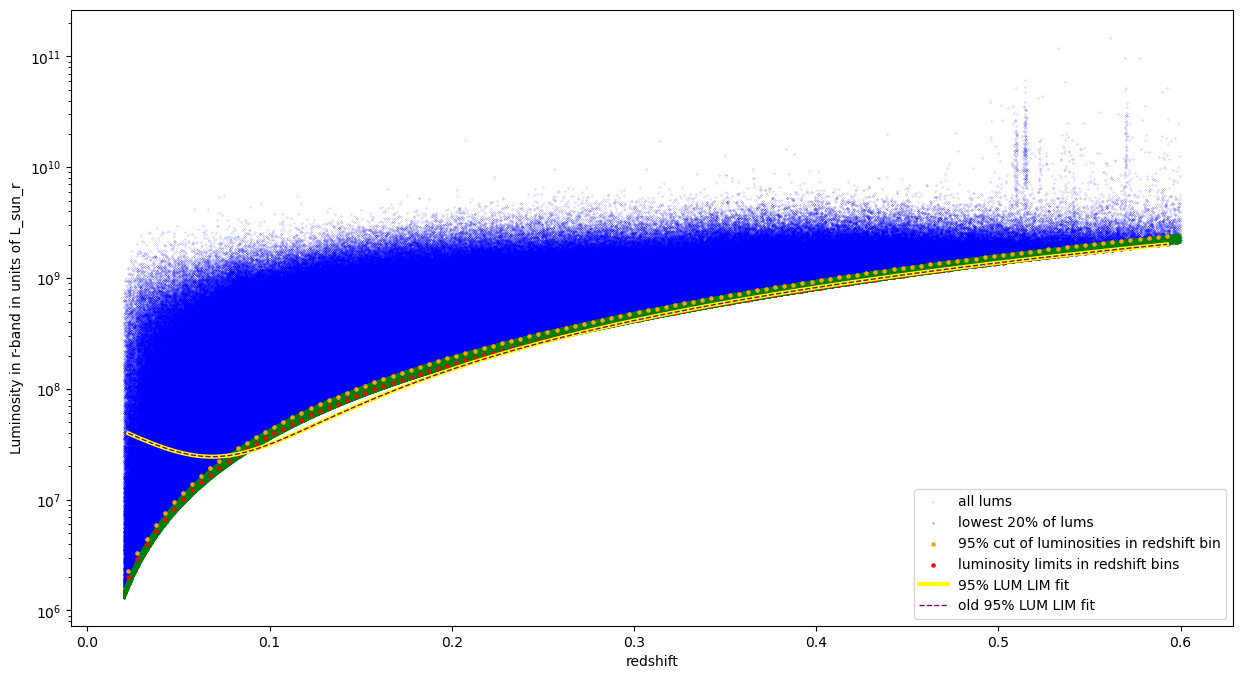

In [73]:
fig, ax = plt.subplots(figsize = (15,8))

ax.scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"]/gs.L_sun_r, s = 0.01, color = "blue", label = "all lums")
ax.scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_R"]/gs.L_sun_r, s = 0.1, color = "green", label ="lowest 20% of lums")

center_z = (bins[:-1] + bins[1:])/2
ax.scatter(center_z, LUM_95/gs.L_sun_r, s = 5, color = "orange", label = "95% cut of luminosities in redshift bin")
ax.scatter(center_z, LUM_LIM_95/gs.L_sun_r, s = 5, color = "red", label ="luminosity limits in redshift bins")

def poly2d(x, a, b, c):
    return a*x**2 + b*x + c

# for the fit to be good, we need to decrease the LUM values, otherwise, they fit doesn't work that well
# normalize_LUM = 10**(7)

coefs_LUM_LIM_95, _ = curve_fit(poly2d, center_z[:int(stop_at)], np.array(LUM_LIM_95[:int(stop_at)])/gs.L_sun_r, p0 = [7251562630.908631, -993318577.5495119, 58433580.69203088])
print("Fit values: ", coefs_LUM_LIM_95[0], coefs_LUM_LIM_95[1], coefs_LUM_LIM_95[2])

ax.plot(center_z, poly2d(center_z, *coefs_LUM_LIM_95), linewidth = 3, color = "yellow", label = "95% LUM LIM fit")
ax.plot(center_z, poly2d(center_z, *[7251562630.908631, -993318577.5495119, 58433580.69203088]), linewidth = 1, linestyle = "dashed", color = "purple", label = "old 95% LUM LIM fit")


ax.set_xlabel("redshift")
ax.set_ylabel("Luminosity in r-band in units of L_sun_r")
ax.set_yscale("log")
#ax.set_xlim(0.095, 0.6)
#ax.set_ylim(3*10**7,3*10**9)
ax.legend(loc = "lower right")
plt.show()

invert to get zmax

$$ax^2+bx+c = a(x-h)^2+k$$ with $$h = -\frac{b}{2a} \text{ and } k = c-ah^2$$

i.e. the inverse of a quadratic is:

$$ f^{-1}(x) = \pm\sqrt{\frac{x-k}{a}}+h$$

To reproduce the physically correct results one has to take the negative solution!

/tmp/ipykernel_227720/3751349324.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((x-k)/a)+h


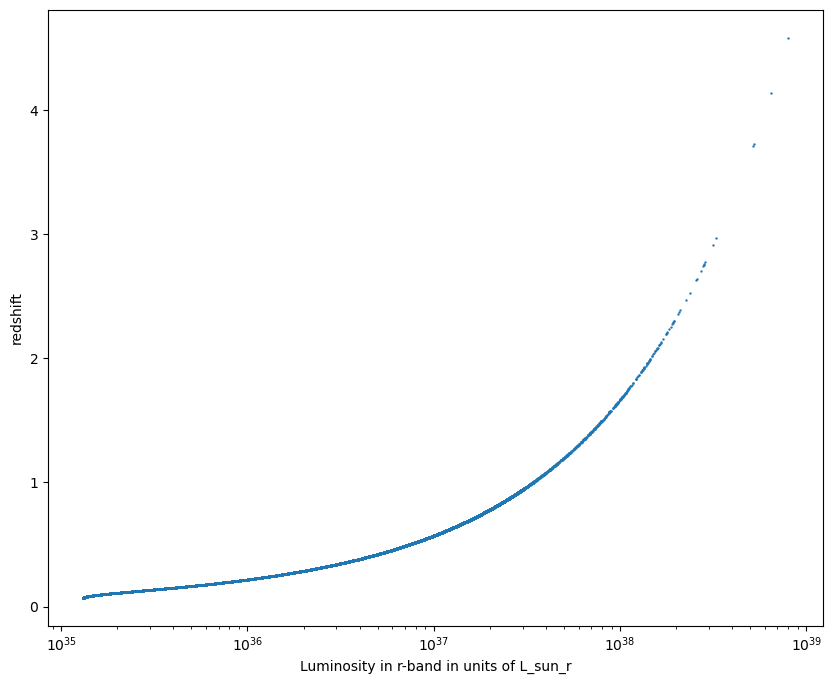

In [180]:
# now plot the inverse:

# from here we can get the z_max values, i.e. the maximum redshift at a certain luminosity that an object could be detected

# inverse is as above

def poly2d_inverse(x, a,h,k):
    return np.sqrt((x-k)/a)+h

a = coefs_LUM_LIM_95[0]
b = coefs_LUM_LIM_95[1]
c = coefs_LUM_LIM_95[2]
h = -b/(2*a)
k = c-a*h**2
inverted_coefs_95 = [a,h,k]

fig, ax = plt.subplots(figsize = (10,8))

#ax.scatter(LUM_LIM_95, center_z, s = 3, color = "red", label ="Calculated luminosity limits, including a offseted z-band magnitude limit")

ax.scatter(ztile_cat_grouped_by_AppMag["LUM_R"], poly2d_inverse(ztile_cat_grouped_by_AppMag["LUM_R"]/gs.L_sun_r, *inverted_coefs_95), s = 0.5)
#ax.vlines(LUM_LIM_95[stop_at-1], 0, 1, label = "limit of fit")


ax.set_xlabel("Luminosity in r-band in units of L_sun_r")
ax.set_ylabel("redshift")
ax.set_xscale("log")
#ax.set_ylim(0,1)
#ax.set_xlim(10,10**5)
#ax.legend()
plt.show()

In [181]:
ztile_cat_grouped_by_AppMag[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,BGS_TARGET,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,int64,float32,float32,float32,float64,float64,float64,float64,float64,float64
39628512461591304,main,dark,20220409,0.5232104210989278,6.441367281246471e-05,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,131074,21.34423,19.499998,18.336449,-22.944699710552882,-24.108249133770656,5.11377092444133e+37,8.122947510778128e+36,3.3158980440905456e+37,8.122933469981502e+36
39627744803293140,main,bright,20220210,0.29393356192632125,5.053998841406768e-06,0,GALAXY,140.3418958135519,-1.7572070594922846,8.420731,15.848966,24.012398,131074,20.186626,19.499998,19.048912,-21.47299117234912,-21.924077216660642,6.840258315172543e+36,2.0942582339236586e+36,8.549047573435154e+36,2.0942546139256338e+36
39628512461591304,main,bright,20220317,0.5233237733268103,0.00014110804655666955,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,131074,21.34423,19.499998,18.336449,-22.945264178866502,-24.108813602084275,5.116430237192587e+37,8.127171684721852e+36,3.3176224095501663e+37,8.127157636623595e+36
39627603929204288,main,bright,20211021,0.09985713084547924,9.501685612959509e-06,0,GALAXY,359.06996685968784,-7.731517222708435,9.3054495,15.848953,23.134731,131074,20.078156,19.499998,19.089338,-18.883915639575875,-19.294575429614937,6.071161529616348e+35,1.9293011292831737e+35,7.875670467120089e+35,1.929297794419228e+35
39628121997053964,main,bright,20220122,0.2046669597299606,6.631007630176025e-05,0,GALAXY,124.08490860435361,14.009380623384853,5.1329536,15.848953,30.459774,131074,20.724081,19.499998,18.790684,-20.582441422326326,-21.291755768639803,3.820708666564449e+36,9.221686027102699e+35,3.7644181027728915e+36,9.221670087098423e+35


In [182]:
np.max(ztile_cat_grouped_by_AppMag["ABS_MAG_R"]), np.min(ztile_cat_grouped_by_AppMag["ABS_MAG_R"])

(-15.287845621798638, -27.923318468433536)

In [227]:
z_max_i = np.array(poly2d_inverse(ztile_cat_grouped_by_AppMag["LUM_R"]/gs.L_sun_r, *inverted_coefs_95))

/tmp/ipykernel_227720/3751349324.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((x-k)/a)+h


In [228]:
np.min(z_max_i)

nan

In [229]:
z_max_i[:5], len(ztile_cat_grouped_by_AppMag)

(array([0.52053982, 0.2924978 , 0.52065929, 0.10806124, 0.21064785]), 4151926)

In [230]:
ztile_cat_z_max = 5

In [231]:
ztile_cat_z_max = hstack([ztile_cat_grouped_by_AppMag, Table({"z_max": z_max_i})])

In [232]:
ztile_cat_z_max[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,BGS_TARGET,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max
,,,,,,,,,,,,,,,,,,,W,W,W,W,
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,int64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39628512461591304,main,dark,20220409,0.5232104210989278,6.441367281246471e-05,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,131074,21.34423,19.499998,18.336449,-22.944699710552882,-24.108249133770656,5.11377092444133e+37,8.122947510778128e+36,3.3158980440905456e+37,8.122933469981502e+36,0.5205398218797724
39627744803293140,main,bright,20220210,0.29393356192632125,5.053998841406768e-06,0,GALAXY,140.3418958135519,-1.7572070594922846,8.420731,15.848966,24.012398,131074,20.186626,19.499998,19.048912,-21.47299117234912,-21.924077216660642,6.840258315172543e+36,2.0942582339236586e+36,8.549047573435154e+36,2.0942546139256338e+36,0.29249780444799556
39628512461591304,main,bright,20220317,0.5233237733268103,0.00014110804655666955,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,131074,21.34423,19.499998,18.336449,-22.945264178866502,-24.108813602084275,5.116430237192587e+37,8.127171684721852e+36,3.3176224095501663e+37,8.127157636623595e+36,0.5206592910569404
39627603929204288,main,bright,20211021,0.09985713084547924,9.501685612959509e-06,0,GALAXY,359.06996685968784,-7.731517222708435,9.3054495,15.848953,23.134731,131074,20.078156,19.499998,19.089338,-18.883915639575875,-19.294575429614937,6.071161529616348e+35,1.9293011292831737e+35,7.875670467120089e+35,1.929297794419228e+35,0.1080612420181652
39628121997053964,main,bright,20220122,0.2046669597299606,6.631007630176025e-05,0,GALAXY,124.08490860435361,14.009380623384853,5.1329536,15.848953,30.459774,131074,20.724081,19.499998,18.790684,-20.582441422326326,-21.291755768639803,3.820708666564449e+36,9.221686027102699e+35,3.7644181027728915e+36,9.221670087098423e+35,0.21064785492726024


In [233]:
#only allow redshifts above 0.1
ztile_cat_z_max = ztile_cat_z_max[ztile_cat_z_max["z_max"] > 0.1]

In [234]:
ztile_cat_z_max[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,BGS_TARGET,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max
,,,,,,,,,,,,,,,,,,,W,W,W,W,
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,int64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39628512461591304,main,dark,20220409,0.5232104210989278,6.441367281246471e-05,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,131074,21.34423,19.499998,18.336449,-22.944699710552882,-24.108249133770656,5.11377092444133e+37,8.122947510778128e+36,3.3158980440905456e+37,8.122933469981502e+36,0.5205398218797724
39627744803293140,main,bright,20220210,0.29393356192632125,5.053998841406768e-06,0,GALAXY,140.3418958135519,-1.7572070594922846,8.420731,15.848966,24.012398,131074,20.186626,19.499998,19.048912,-21.47299117234912,-21.924077216660642,6.840258315172543e+36,2.0942582339236586e+36,8.549047573435154e+36,2.0942546139256338e+36,0.29249780444799556
39628512461591304,main,bright,20220317,0.5233237733268103,0.00014110804655666955,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,131074,21.34423,19.499998,18.336449,-22.945264178866502,-24.108813602084275,5.116430237192587e+37,8.127171684721852e+36,3.3176224095501663e+37,8.127157636623595e+36,0.5206592910569404
39627603929204288,main,bright,20211021,0.09985713084547924,9.501685612959509e-06,0,GALAXY,359.06996685968784,-7.731517222708435,9.3054495,15.848953,23.134731,131074,20.078156,19.499998,19.089338,-18.883915639575875,-19.294575429614937,6.071161529616348e+35,1.9293011292831737e+35,7.875670467120089e+35,1.929297794419228e+35,0.1080612420181652
39628121997053964,main,bright,20220122,0.2046669597299606,6.631007630176025e-05,0,GALAXY,124.08490860435361,14.009380623384853,5.1329536,15.848953,30.459774,131074,20.724081,19.499998,18.790684,-20.582441422326326,-21.291755768639803,3.820708666564449e+36,9.221686027102699e+35,3.7644181027728915e+36,9.221670087098423e+35,0.21064785492726024


In [235]:
np.min(ztile_cat_z_max["Z"]), np.max(ztile_cat_z_max["Z"])

(0.02000172125340918, 0.5999935242288166)

In [236]:
 z_min_data, z_max_data

(0.02000172125340918, 0.5999935242288166)

In [237]:
V_max_i = gs.V_max(area, z_min_data, z_max_data, ztile_cat_z_max["z_max"])

In [238]:
len(V_max_i)

3971831

In [239]:
len(ztile_cat_z_max)

3971831

In [240]:
V_max_i[:5]

<Quantity [8.75006607e+08, 1.14704831e+08, 8.75729562e+08, 4.17991299e+06,
           3.75301219e+07] Mpc3>

In [241]:
ztile_wVmax = hstack([ztile_cat_z_max, Table({"V_MAX": V_max_i})])

In [242]:
ztile_wVmax

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,BGS_TARGET,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max,V_MAX
,,,,,,,,,,,,,,,,,,,W,W,W,W,,Mpc3
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,int64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64
39628512461591304,main,dark,20220409,0.5232104210989278,6.441367281246471e-05,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,131074,21.34423,19.499998,18.336449,-22.944699710552882,-24.108249133770656,5.11377092444133e+37,8.122947510778128e+36,3.3158980440905456e+37,8.122933469981502e+36,0.5205398218797724,875006607.4145677
39627744803293140,main,bright,20220210,0.29393356192632125,5.053998841406768e-06,0,GALAXY,140.3418958135519,-1.7572070594922846,8.420731,15.848966,24.012398,131074,20.186626,19.499998,19.048912,-21.47299117234912,-21.924077216660642,6.840258315172543e+36,2.0942582339236586e+36,8.549047573435154e+36,2.0942546139256338e+36,0.29249780444799556,114704830.92514819
39628512461591304,main,bright,20220317,0.5233237733268103,0.00014110804655666955,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,131074,21.34423,19.499998,18.336449,-22.945264178866502,-24.108813602084275,5.116430237192587e+37,8.127171684721852e+36,3.3176224095501663e+37,8.127157636623595e+36,0.5206592910569404,875729561.6814485
39627603929204288,main,bright,20211021,0.09985713084547924,9.501685612959509e-06,0,GALAXY,359.06996685968784,-7.731517222708435,9.3054495,15.848953,23.134731,131074,20.078156,19.499998,19.089338,-18.883915639575875,-19.294575429614937,6.071161529616348e+35,1.9293011292831737e+35,7.875670467120089e+35,1.929297794419228e+35,0.1080612420181652,4179912.9945821133
39628121997053964,main,bright,20220122,0.2046669597299606,6.631007630176025e-05,0,GALAXY,124.08490860435361,14.009380623384853,5.1329536,15.848953,30.459774,131074,20.724081,19.499998,18.790684,-20.582441422326326,-21.291755768639803,3.820708666564449e+36,9.221686027102699e+35,3.7644181027728915e+36,9.221670087098423e+35,0.21064785492726024,37530121.90750779
39628476700950758,main,bright,20220516,0.3259818141363389,6.238839403178226e-05,0,GALAXY,263.6795480562096,29.86452318803688,3.723798,15.848975,34.660423,131074,21.072535,19.499996,18.650415,-21.73234125303462,-22.581922017805127,1.2537484905573515e+37,2.6593179432084494e+36,1.085567959416129e+37,2.6593085912540695e+36,0.3227121680143727,161187475.12056193
39632980439731049,main,bright,20211119,0.3920554604374992,0.0001069086853427979,0,GALAXY,150.6531448929639,34.96696871050341,2.9577417,15.848981,37.448135,514,21.3226,19.499996,18.566425,-22.20016403625852,-23.133734898074927,2.084181685521736e+37,4.091658480477172e+36,1.670267935524208e+37,4.091644091448006e+36,0.3866989247154645,303533037.5226392
39628424783860798,main,bright,20211019,0.11867997911647223,2.984646281755426e-05,0,GALAXY,345.3853896159446,27.331097062096124,10.300225,15.848995,22.347721,131074,19.967884,19.499996,19.126917,-19.2856263190302,-19.658705618956958,8.490316178431994e+35,2.793085886293674e+35,1.1401738019992318e+36,2.7930760639210415e+35,0.1299182095423823,7595525.001611334


In [243]:
lower_limit_lum = np.min(ztile_wVmax["LUM_R"])
upper_limit_lum = np.max(ztile_wVmax["LUM_R"])
print("lower and upper limit of LUM_R: ", lower_limit_lum, upper_limit_lum)

num_of_lum_bins = 100

lum_bins = np.logspace(np.log10(lower_limit_lum), np.log10(upper_limit_lum), num_of_lum_bins, endpoint = True)

print("num of bins", len(lum_bins))
print(lum_bins[0:10])

lower and upper limit of LUM_R:  1.705028682224034e+35 7.964548294830565e+38
num of bins 100
[1.70502868e+35 1.85693471e+35 2.02237448e+35 2.20255378e+35
 2.39878578e+35 2.61250066e+35 2.84525604e+35 3.09874827e+35
 3.37482488e+35 3.67549796e+35]


In [244]:
len(lum_bins)

100

In [245]:
def calc_phi_j(V_max_i, lum_bins):
    
    phi_j = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    for q in range(len(phi_j)):
        
        ii = ztile_wVmax["LUM_R"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_R"]< lum_bins[q+1]
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX"]
        one_ov_dat = [1/vmax for vmax in dat]
        phi_j[cnt] = np.sum(one_ov_dat)
        cnt += 1
    return phi_j

In [246]:
phi_j = calc_phi_j(V_max_i, lum_bins)

In [247]:
len(phi_j)

99

In [248]:
phi_j[:5]

[0.0050625243847200315,
 0.004619679775480433,
 0.004285904691976213,
 0.004028733439377748,
 0.003779300005265994]

In [249]:
center_lum_bins = lum_bins[1:]-(lum_bins[2]-lum_bins[1])/2

In [250]:
len(center_lum_bins)

99

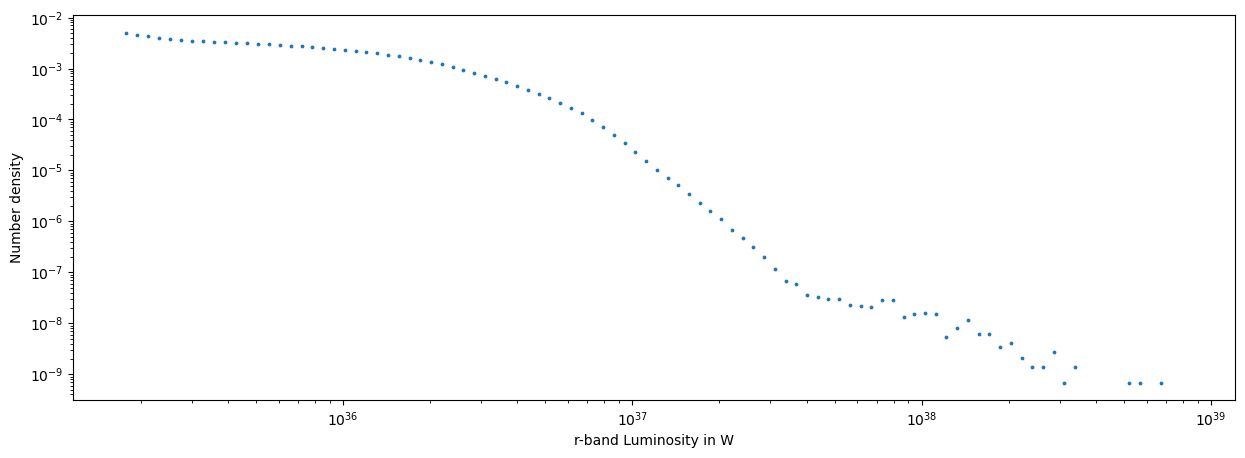

In [251]:
fig, ax = plt.subplots(figsize = (15,5))

ax.scatter(center_lum_bins, phi_j, s = 3)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r-band Luminosity in W")
ax.set_ylabel("Number density")

plt.show()

In [252]:
# Fit a schechter function to the data
# for this we need to go from the Luminosities back to the magnitudes...

In [253]:
len(center_lum_bins), len(phi_j)

(99, 99)

In [254]:
center_lum_bins, phi_j = np.array(center_lum_bins), np.array(phi_j)

In [255]:
center_lum_bins.shape, phi_j.shape

((99,), (99,))

In [256]:
center_lum_bins, phi_j

(array([1.77421482e+35, 1.93965460e+35, 2.11983389e+35, 2.31606589e+35,
        2.52978077e+35, 2.76253615e+35, 3.01602838e+35, 3.29210499e+35,
        3.59277807e+35, 3.92023900e+35, 4.27687439e+35, 4.66528347e+35,
        5.08829707e+35, 5.54899819e+35, 6.05074453e+35, 6.59719292e+35,
        7.19232602e+35, 7.84048127e+35, 8.54638258e+35, 9.31517471e+35,
        1.01524608e+36, 1.10643432e+36, 1.20574678e+36, 1.31390729e+36,
        1.43170413e+36, 1.55999584e+36, 1.69971744e+36, 1.85188725e+36,
        2.01761431e+36, 2.19810648e+36, 2.39467923e+36, 2.60876523e+36,
        2.84192478e+36, 3.09585719e+36, 3.37241320e+36, 3.67360839e+36,
        4.00163795e+36, 4.35889263e+36, 4.74797618e+36, 5.17172433e+36,
        5.63322545e+36, 6.13584306e+36, 6.68324035e+36, 7.27940688e+36,
        7.92868764e+36, 8.63581474e+36, 9.40594186e+36, 1.02446819e+37,
        1.11581477e+37, 1.21529969e+37, 1.32364802e+37, 1.44164941e+37,
        1.57016390e+37, 1.71012812e+37, 1.86256216e+37, 2.028577

In [257]:
fit_data = hstack([Table({"LUM": center_lum_bins}), Table({"ABS_MAG_R": gs.M(center_lum_bins*u.W, band = "r")}), Table({"N": phi_j})])

In [258]:
fit_data

LUM,ABS_MAG_R,N
,,
float64,float64,float64
1.774214816661739e+35,-18.792931097716547,0.0050625243847200315
1.9396545950182065e+35,-18.889726592312282,0.004619679775480433
2.1198338901581983e+35,-18.986170170843767,0.004285904691976213
2.3160658890139627e+35,-19.082292869140772,0.004028733439377748
2.5297807742065728e+35,-19.178122812568713,0.003779300005265994
2.7625361475361904e+35,-19.273685516888758,0.0036506886446548525
3.0160283821317562e+35,-19.369004153592407,0.003522064126816474
3.2921049859971113e+35,-19.46409978458654,0.003420317219370402


In [259]:
fit_data = fit_data[fit_data["N"] != 0]

In [260]:
fit_data[:55]

LUM,ABS_MAG_R,N
,,
float64,float64,float64
1.774214816661739e+35,-18.792931097716547,0.0050625243847200315
1.9396545950182065e+35,-18.889726592312282,0.004619679775480433
2.1198338901581983e+35,-18.986170170843767,0.004285904691976213
2.3160658890139627e+35,-19.082292869140772,0.004028733439377748
2.5297807742065728e+35,-19.178122812568713,0.003779300005265994
2.7625361475361904e+35,-19.273685516888758,0.0036506886446548525
3.0160283821317562e+35,-19.369004153592407,0.003522064126816474
3.2921049859971113e+35,-19.46409978458654,0.003420317219370402


In [261]:
np.array(fit_data["N"])

array([5.06252438e-03, 4.61967978e-03, 4.28590469e-03, 4.02873344e-03,
       3.77930001e-03, 3.65068864e-03, 3.52206413e-03, 3.42031722e-03,
       3.35305983e-03, 3.25245432e-03, 3.19466550e-03, 3.12057278e-03,
       3.04259048e-03, 2.96019813e-03, 2.86238534e-03, 2.77076131e-03,
       2.70945327e-03, 2.62157323e-03, 2.53562591e-03, 2.44721376e-03,
       2.33894322e-03, 2.23112683e-03, 2.12834090e-03, 2.01740209e-03,
       1.87912525e-03, 1.74033402e-03, 1.61083909e-03, 1.47940864e-03,
       1.35119768e-03, 1.21036238e-03, 1.08232767e-03, 9.52979273e-04,
       8.34636173e-04, 7.26127736e-04, 6.26604180e-04, 5.33809814e-04,
       4.52884121e-04, 3.79904328e-04, 3.15463912e-04, 2.60389224e-04,
       2.13215597e-04, 1.68950143e-04, 1.31195812e-04, 9.72864523e-05,
       7.08205634e-05, 5.02167450e-05, 3.46405384e-05, 2.30186363e-05,
       1.53332577e-05, 1.01382463e-05, 7.23974304e-06, 5.08820028e-06,
       3.51181565e-06, 2.29174182e-06, 1.56817786e-06, 1.10586288e-06,
      

In [262]:
# get model
Schechter = models.Schechter1D()
# set fitting algorithm
fit_alg = fitting.LMLSQFitter() # only this Fitter is able to fit, all others from here: https://docs.astropy.org/en/stable/modeling/fitting.html fail
# perform fit

fit_lim = len(fit_data)-1

schechter_fit = fit_alg(Schechter, np.array(fit_data["ABS_MAG_R"][:fit_lim]), np.array(fit_data["N"][:fit_lim]))

print(schechter_fit)

Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          phi_star              m_star              alpha       
    -------------------- ------------------- -------------------
    0.002736913799912165 -21.773058677247036 -1.2317647996578647


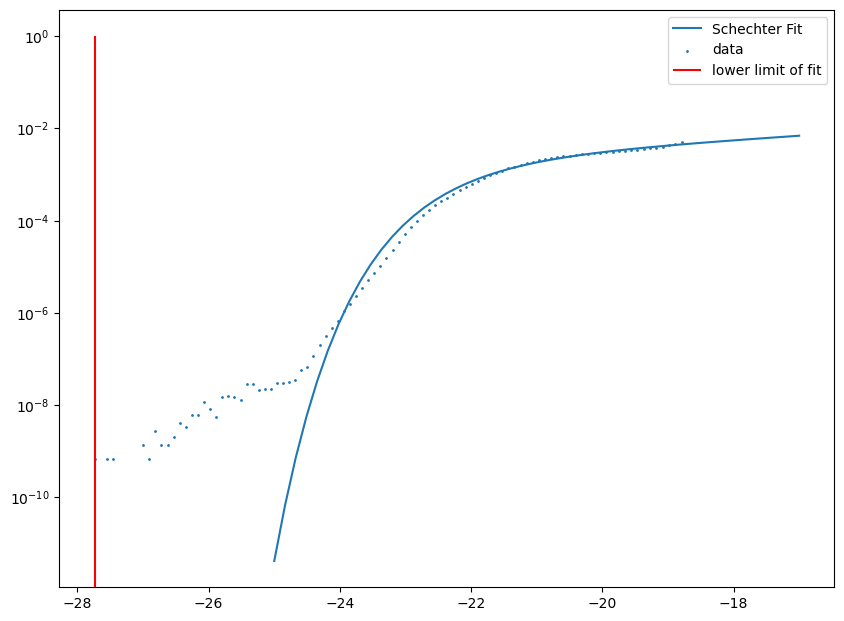

In [263]:
fig, ax = plt.subplots(figsize = (10,7.5))

x = np.linspace(-25, -17)

ax.plot(x, schechter_fit(x), label = "Schechter Fit")
ax.scatter(np.array(fit_data["ABS_MAG_R"]), np.array(fit_data["N"]), label = "data", s = 1)
ax.vlines(fit_data["ABS_MAG_R"][fit_lim], 0,1, label = "lower limit of fit", color = "red")


ax.set_yscale('log')
#ax.set_ylim(10**-23, 10**-1)
ax.legend()
plt.show()

In [264]:
np.max(np.array(fit_data["N"]))

0.0050625243847200315

In [265]:
 0.00021404293387048377/0.0089

0.024049767850616154

In [266]:
# simple calculator for volume (assuming the sky area has already been calculated)
volume = area/3*(Distance(z=z_max_data, cosmology=Planck18)**3-Distance(z=z_min_data, cosmology=Planck18)**3)

In [267]:
print(volume)

4800145595451.962 Mpc3


In [268]:
from scipy import integrate

In [269]:
integrate.quad(schechter_fit, -25, -17)

(0.018639937432599056, 4.288688641270591e-12)

In [270]:
integrate.quad(schechter_fit, -25, -24)

(8.027082091538549e-08, 8.911851358582356e-22)